### Importing Required Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.feature_selection import RFE, RFECV
import seaborn as sns

sns.set()
import pickle

from imblearn.under_sampling import InstanceHardnessThreshold,RandomUnderSampler,\
TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

# Preprocessing and helper functions
from utils import *

### Importing the data

Preprocessing done (in utils.py file):
1. Corrected some spelling/formatting mistakes in categorical features
2. Target guided (mean) encoding for profession, city and state
3. One-hot encoding for married and car_ownership
4. Label encoding for house_ownership
5. Binning for income, age, experience, current_house_years, current_job_years
6. Algebraic combinations of numerical features

In [2]:
df_train, df_test = import_data()
df_train, df_test = preprocess(df_train, df_test)
Y_all = df_train['risk_flag']
X_all = df_train.drop(['risk_flag'],axis=1)
cols = X_all.columns.to_list()

(252000, 13) (28000, 12)


D:\Miniconda\envs\bankd\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Miniconda\envs\bankd\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [26]:
# X_all.columns

In [27]:
# Hyperparameter tuning didn't improve the score, except criterion and class_weight,
# default parameters were used

clf = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, verbose=1, \
                            criterion='entropy', class_weight={0:1,1:10})

### Selected columns for training based on feature importance values as well as roc_auc_score

In [28]:
selected_cols = ['car_ownership_no',
                 'house_ownership_norent noown','house_ownership_rented',\
                 'age_bnd', 'income', 'experience', \
                 'profession_OF', 'city_OF', 'state_OF',\
                 'current_house_years_bnd',\
                 'current_job_years_bnd']
Xs_all = X_all[selected_cols]

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(Xs_all, \
                                Y_all,test_size=0.1,random_state=5,shuffle=True)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((226800, 11), (226800,), (25200, 11), (25200,))

In [29]:
train(clf,[X_train, X_test, Y_train, Y_test])
predict(clf,[X_train, X_test, Y_train, Y_test], thresholds=[0.5])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.2s


Threshold = 0.5
Default Training ROC AUC = 0.957561968927548
Default Test ROC AUC = 0.8408256667521053
[[20169  1945]
 [  711  2375]]



[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    3.5s finished


I chose the thresholds by varying the random state for the train-test split, and choosing the threshold with maximum score on an average. However, we can use cross-validation for more reliable results.

In [33]:
thresholds = [0.02,0.03,0.04,0.05,0.06,0.07,0.1]
thresholds = [i/100 for i in range(10)]
predict(clf,[X_train, X_test, Y_train, Y_test], thresholds=thresholds)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    3.4s finished


Threshold = 0.0
Default Training ROC AUC = 0.5
Default Test ROC AUC = 0.5
[[    0 22114]
 [    0  3086]]

Threshold = 0.01
Default Training ROC AUC = 0.957561968927548
Default Test ROC AUC = 0.8919688884869313
[[17336  4778]
 [    0  3086]]

Threshold = 0.02
Default Training ROC AUC = 0.957561968927548
Default Test ROC AUC = 0.8919688884869313
[[17336  4778]
 [    0  3086]]

Threshold = 0.03
Default Training ROC AUC = 0.957561968927548
Default Test ROC AUC = 0.8919688884869313
[[17336  4778]
 [    0  3086]]

Threshold = 0.04
Default Training ROC AUC = 0.957561968927548
Default Test ROC AUC = 0.89208193904314
[[17341  4773]
 [    0  3086]]

Threshold = 0.05
Default Training ROC AUC = 0.957561968927548
Default Test ROC AUC = 0.8919651372306269
[[17343  4771]
 [    1  3085]]

Threshold = 0.06
Default Training ROC AUC = 0.957561968927548
Default Test ROC AUC = 0.891983996085564
[[17351  4763]
 [    2  3084]]

Threshold = 0.07
Default Training ROC AUC = 0.957561968927548
Default Test ROC AU

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


Text(0.5, 0, 'FPR')

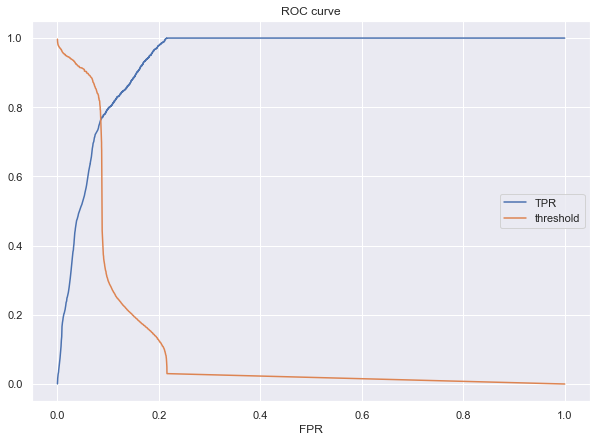

In [36]:
fpr, tpr, thresholds = roc_curve(Y_test,clf.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,7))
plt.plot(fpr[1:], tpr[1:])
plt.plot(fpr[1:], thresholds[1:])
plt.legend(['TPR','threshold'])
plt.title("ROC curve")
plt.xlabel("FPR")

### Train on all data

In [8]:
clf

ExtraTreesClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
                     n_estimators=200, n_jobs=-1, verbose=1)

In [9]:
print(Xs_all.shape)

(252000, 11)


In [18]:
clf.n_estimators = 2000
Xs_all = Xs_all[selected_cols]
clf.fit(Xs_all, Y_all)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.3min finished


ExtraTreesClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
                     n_estimators=2000, n_jobs=-1, verbose=1)

### Make Predictions on Final Test Set

In [20]:
predictions = clf.predict_proba(df_test[selected_cols])[:,1]
threshold = 0.03
predictions[predictions>=threshold] = 1
predictions[predictions<threshold] = 0

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    4.5s finished


In [21]:
predictions.shape

(28000,)

In [24]:
df_predictions = pd.DataFrame(df_test['id'])
df_predictions['risk_flag'] = predictions.astype(int)
df_predictions

,id,risk_flag
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,1


In [25]:
df_predictions['risk_flag'].value_counts()

0    19232
1     8768
Name: risk_flag, dtype: int64

In [33]:
df_predictions.to_csv("D:/Code/Projects/Bank Default Hackathon/predictions_vl4.csv",\
                     index=False)